In [ ]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from utils.plot_config import set_matplotlib_config, blend_legend_color_with_alpha

set_matplotlib_config()
SAVE_DIR = Path('./figures/')
EXPECTILE_RUN = Path(
    '/net/argon/landclim/kraftb/machflow_engression/runs_quantiles/default/xval/fold_000/preds.zarr/')
ENGRESSION_RUN = Path(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/')

In [ ]:
exp = xr.open_zarr(
    EXPECTILE_RUN
).sel(time=slice('2017', '2022'))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

eng = xr.open_zarr(
    ENGRESSION_RUN
).sel(beta=0.67, esl=5, nl=100).sel(time=slice('2017', '2022'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

In [3]:
from scipy.signal import welch

def compute_psd(signal, fs=2.5):
    freqs, psd = welch(signal, fs=fs, nperseg=min(len(signal) // 6, 1024 * 2))
    return freqs, psd

In [4]:
exp_freqs, exp_psd = xr.apply_ufunc(
    compute_psd,
    exp,                                        # Observations with ["time"]
    input_core_dims=[['time']],               # Observations have no "quantile", quantiles do
    output_core_dims=[('frequency',), ('frequency',)],              # Output is scalar per observation
    # exclude_dims={'t'},
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.float32, np.float32],           # Output type
    # kwargs={'nlags': 40}
)

exp_psd['frequency'] = exp_freqs.Qmm.isel(station=0)
exp_psd = exp_psd.where(~exp_psd.Qmm.isnull().all('frequency'), drop=True)
exp_psd = exp_psd / exp_psd.Qmm.max(dim='frequency')
exp_psd = exp_psd.assign_coords(periodicity=('frequency', 1 / exp_psd.frequency.data))

/tmp/ipykernel_2627/694892901.py:16: RuntimeWarning: divide by zero encountered in divide
  exp_psd = exp_psd.assign_coords(periodicity=('frequency', 1 / exp_psd.frequency.data))


In [5]:
eng_freqs, eng_psd = xr.apply_ufunc(
    compute_psd,
    eng,                                        # Observations with ["time"]
    input_core_dims=[['time']],               # Observations have no "quantile", quantiles do
    output_core_dims=[('frequency',), ('frequency',)],              # Output is scalar per observation
    # exclude_dims={'t'},
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.float32, np.float32],           # Output type
    # kwargs={'nlags': 40}
)

eng_psd['frequency'] = eng_freqs.Qmm.isel(station=0)
eng_psd = eng_psd.where(~eng_psd.Qmm.isnull().all('frequency'), drop=True)
eng_psd = eng_psd / eng_psd.Qmm.max(dim='frequency')
eng_psd = eng_psd.assign_coords(periodicity=('frequency', 1 / eng_psd.frequency.data))

/tmp/ipykernel_2627/3616026333.py:16: RuntimeWarning: divide by zero encountered in divide
  eng_psd = eng_psd.assign_coords(periodicity=('frequency', 1 / eng_psd.frequency.data))


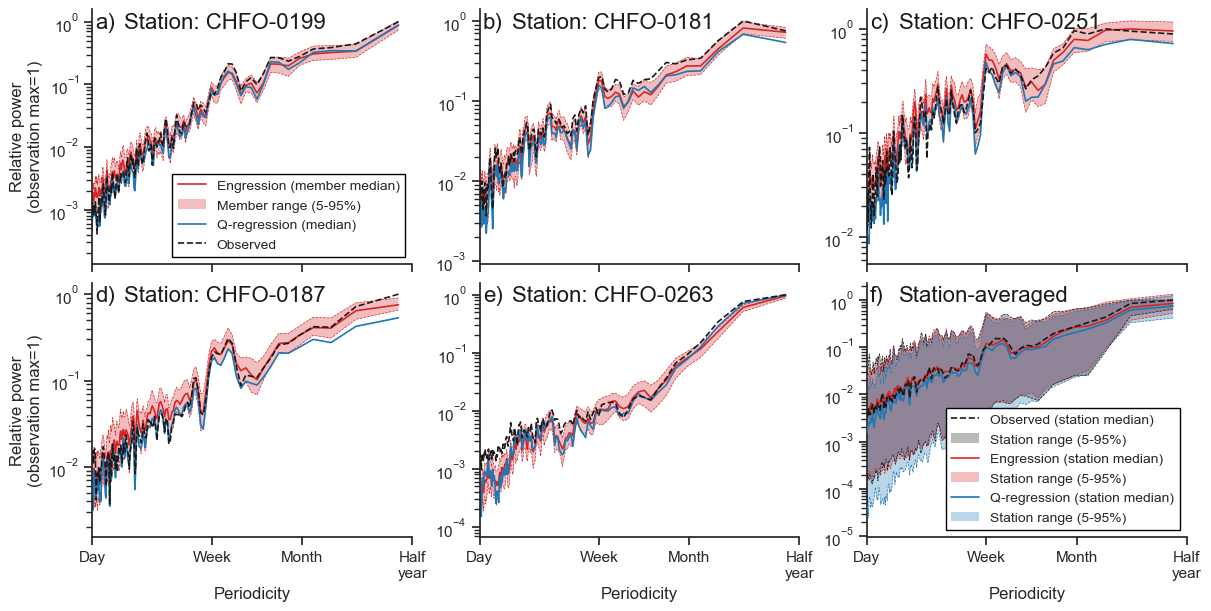

In [7]:
rs = np.random.RandomState(44)
stations = rs.permutation(eng_psd.station.values)[:5]

obs_ls = dict(
    lw=1.2,
    ls='--',
    color='k'
)
median_ls = dict(
    lw=1.2,
    ls='-'
)
range_ls = dict(
    lw=0.5,
    ls='--'
)

fig = plt.figure(figsize=(12, 6), constrained_layout=True)

gs = fig.add_gridspec(2, 3, wspace=0.0)

axes = [fig.add_subplot(gs[0, 0])]
for i in range(1, len(stations)):
    axes.append(fig.add_subplot(gs[i // 3, i % 3]))

axs = fig.add_subplot(gs[-1, -1])

for i, (station, ax) in enumerate(zip(stations, axes)):
    eng_psd_sel = eng_psd.sel(station=station)
    exp_psd_sel = exp_psd.sel(station=station).sel(member=0.5, method='nearest')
    med = eng_psd_sel.Qmm_mod.median('member')
    low = eng_psd_sel.Qmm_mod.quantile(0.05, 'member')
    high = eng_psd_sel.Qmm_mod.quantile(0.95, 'member')

    ax.plot(med.periodicity, med, color='tab:red', label='Engression (member median)', **median_ls)
    ax.plot(low.periodicity, low, color='tab:red', **range_ls)
    ax.plot(high.periodicity, high, color='tab:red', **range_ls)

    ax.fill_between(
        x=eng_psd_sel.periodicity, y1=low, y2=high, ec='none', fc='tab:red', alpha=0.3, zorder=-20,
        label='Member range (5-95%)')

    med = exp_psd_sel.Qmm_mod

    ax.plot(med.periodicity, med, color='tab:blue', label='Q-regression (median)', **median_ls)

    ax.set_title('')

    ax.annotate(f'Station: {station}', xy=(0.1, 0.99), xycoords='axes fraction', fontsize=16,
            ha='left', va='top', color='k')

    ax.plot(eng_psd_sel.periodicity, eng_psd_sel.Qmm, zorder=20, label='Observed', **obs_ls)


# eng_psd_sel = eng_psd.sel(frequency=slice(0, 1.0))
eng_psd_sel = eng_psd
exp_psd_sel = exp_psd
med = eng_psd_sel.Qmm.median('station')
low = eng_psd_sel.Qmm.quantile(0.05, 'station')
high = eng_psd_sel.Qmm.quantile(0.95, 'station')

axs.plot(med.periodicity, med, label='Observed (station median)', zorder=20, **obs_ls)
axs.plot(low.periodicity, low, color='k', zorder=20, **range_ls)
axs.plot(high.periodicity, high, color='k', zorder=20, **range_ls)

axs.fill_between(
    x=eng_psd_sel.periodicity, y1=low, y2=high, ec='none', fc='k', alpha=0.3, zorder=-20,
    label='Station range (5-95%)')

eng_psd_sel = eng_psd_sel.median('member')
med = eng_psd_sel.Qmm_mod.median('station')
low = eng_psd_sel.Qmm_mod.quantile(0.05, 'station')
high = eng_psd_sel.Qmm_mod.quantile(0.95, 'station')

axs.plot(med.periodicity, med, color='tab:red', label='Engression (station median)', zorder=19, **median_ls)
axs.plot(low.periodicity, low, color='tab:red', zorder=19, **range_ls)
axs.plot(high.periodicity, high, color='tab:red', zorder=19, **range_ls)

axs.fill_between(
    x=eng_psd_sel.periodicity, y1=low, y2=high, ec='none', fc='tab:red', alpha=0.3, zorder=-20,
    label='Station range (5-95%)')

exp_psd_sel = exp_psd_sel.sel(member=0.5, method='nearest')
med = exp_psd_sel.Qmm_mod.median('station')
low = exp_psd_sel.Qmm_mod.quantile(0.05, 'station')
high = exp_psd_sel.Qmm_mod.quantile(0.95, 'station')

axs.plot(med.periodicity, med, color='tab:blue', label='Q-regression (station median)', zorder=19, **median_ls)
axs.plot(low.periodicity, low, color='tab:blue', zorder=19, **range_ls)
axs.plot(high.periodicity, high, color='tab:blue', zorder=19, **range_ls)

axs.fill_between(
    x=exp_psd_sel.periodicity, y1=low, y2=high, ec='none', fc='tab:blue', alpha=0.3, zorder=-20,
    label='Station range (5-95%)')

axs.annotate('Station-averaged', xy=(0.1, 0.99), xycoords='axes fraction', fontsize=16,
        ha='left', va='top', color='k')

legend = axes[0].legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), ncol=1)
legend.set_zorder(102)
blend_legend_color_with_alpha(legend=legend, indices=[1], alpha=0.3)
legend = axs.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), ncol=1)
legend.set_zorder(102)
blend_legend_color_with_alpha(legend=legend, indices=[1,  3, 5], alpha=0.3)

for i, (ax, label) in enumerate(zip(axes + [axs], range(ord('a'), ord('z')+1)[:len(stations) + 1])):
    ax.annotate(f'{chr(label)})', xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
            ha='left', va='top', color='k')

    ax.spines[['top', 'right']].set_visible(False)
    ax.set_rasterization_zorder(-5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 365 / 2)

    # ax.set_ylim(0, 1.5)
    ax.set_xticks([1, 7, 30.41, 365 / 2])
    ax.set_xticks([], minor=True)
    if i > 2:
        ax.set_xticklabels(['Day', 'Week', 'Month', 'Half\nyear'], minor=False)
        ax.set_xlabel('Periodicity')
    else:
        ax.set_xticklabels([])
        ax.set_xlabel('')

    if i in [0, 3]:
        ax.set_ylabel('Relative power\n(observation max=1)')
    else:
        ax.set_ylabel('')

    ax.set_title('')

fig.savefig(SAVE_DIR / 'power_spectrums.eps', dpi=250, bbox_inches='tight')